## Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

## Uncertain Space

In [4]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [5]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':convert_from('kN',150),'n_pax':150.0,'area':180.0,'ar':9.0,'fuel_type':'kerosene','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [7]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=10000)

    INFO - 14:45:48: *** Start Sampling execution ***
    INFO - 14:45:48: Sampling
    INFO - 14:45:48:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:45:48:    MDO formulation: MDF
    INFO - 14:45:48: Running the algorithm OT_MONTE_CARLO:
    INFO - 14:47:47:    100%|██████████| 10000/10000 [01:58<00:00, 84.35 it/sec]
    INFO - 14:47:47: *** End Sampling execution (time: 0:01:58.956386) ***


In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [10]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.99999721]),
 'length': array([nan]),
 'mtom': array([0.99999659]),
 'span': array([1.]),
 'tofl': array([0.99999651]),
 'vapp': array([0.99999667]),
 'vz': array([0.99999664])}

In [11]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([0.00027276]),
 'length': array([0.]),
 'mtom': array([0.24062904]),
 'span': array([0.]),
 'tofl': array([0.00659592]),
 'vapp': array([4.69027133e-06]),
 'vz': array([0.00049532])}

In [12]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([3.14387586e-05]),
 'length': array([0.]),
 'mtom': array([0.62895428]),
 'span': array([0.]),
 'tofl': array([0.01748192]),
 'vapp': array([0.00025575]),
 'vz': array([0.00020619])}

In [13]:
from matplotlib import pyplot as plt

from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [14]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00656559]),
 'cef': array([1.00654216]),
 'fm': array([1.19250012]),
 'length': array([37.]),
 'mtom': array([75022.90686675]),
 'sef': array([1.00672306]),
 'span': array([40.24922359]),
 'tofl': array([1126.89174685]),
 'vapp': array([56.74835573]),
 'vz': array([7.36315353])}

In [15]:
variance = statistics.compute_variance()
variance

{'aef': array([7.24298412e-05]),
 'cef': array([7.24760979e-05]),
 'fm': array([0.00035474]),
 'length': array([0.]),
 'mtom': array([115991.9293473]),
 'sef': array([7.2424787e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([87.48475146]),
 'vapp': array([0.01961421]),
 'vz': array([0.01267109])}

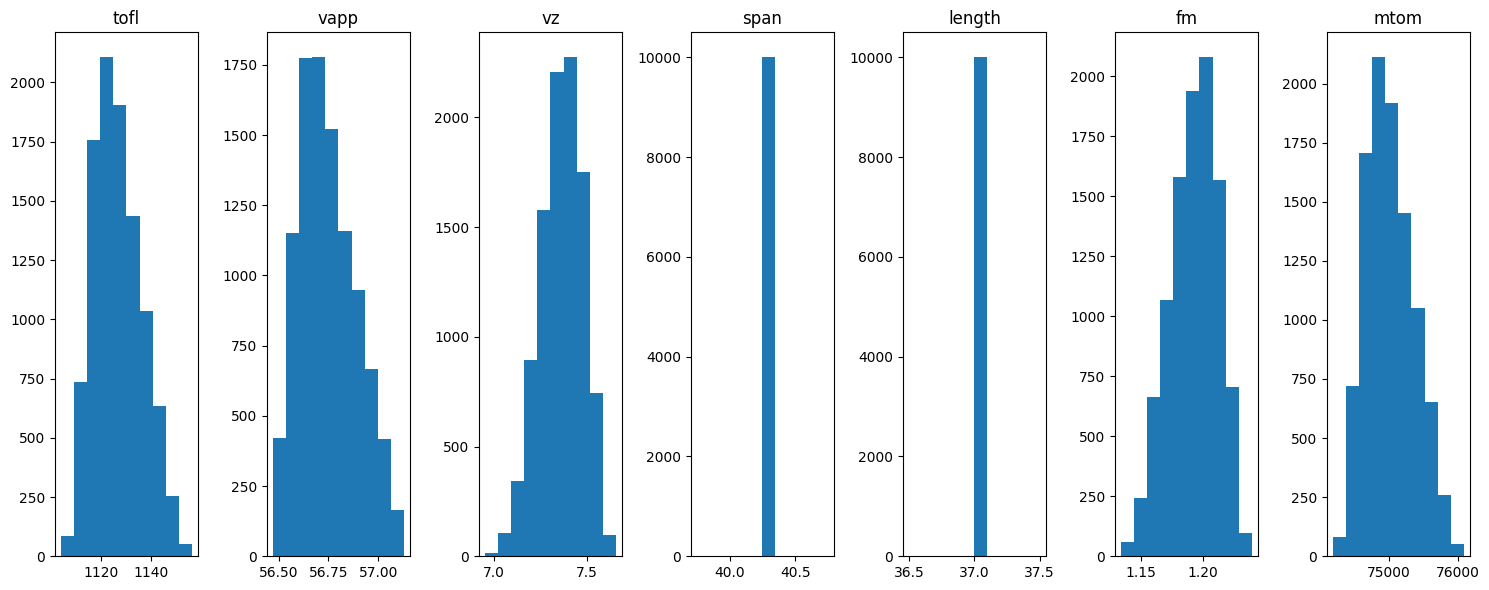

In [16]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [17]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [18]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 10000)

 WARNING - 14:49:38: No coupling in MDA, switching chain_linearize to True.
    INFO - 14:49:38: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 14:49:38: SobolAnalysisSamplingPhase
    INFO - 14:49:38:    Disciplines: RBF_Sampling
    INFO - 14:49:38:    MDO formulation: MDF
    INFO - 14:49:38: Running the algorithm OT_SOBOL_INDICES:
    INFO - 14:53:35:    100%|██████████| 10000/10000 [03:57<00:00, 42.14 it/sec]
    INFO - 14:53:35: *** End SobolAnalysisSamplingPhase execution (time: 0:03:57.754271) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.024023  0.997598  1.153923   37.0  74917.474587   
1          0.996470  1.011547  1.018636  1.192744   37.0  75470.101859   
2          1.012159  1.006022  0.995494  1.188066   37.0  74627.756616   
3          0.999643  1.003814  1.017131  1.204916   37.0  75340.307446   
4          0.999603  1.012760  1.010630  1.187224   37.0  75202.355956   
...             ...       ...       ...       ...    ...           ...   
9995       0.992415  1.015949  1.005742  1.188163   37.0  75012.752727   
9996       1.007491  1.000054  1.027677  1.204587   37.0  75739.001684   
9997       0.991402  1.000257  1.018717  1.220411   37.0  75307.953230   
9998       1.000940  1.012573  0.995685  1.186260   37.0  74645.916577   
9999       1.007142  1.000156  1.001400  1.204731   37.0  74749.565418   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          40.249224  1123.979578  56.598068  7.361378  
1          40.249224  1139.177855  56.944333  7.308137  
2          40.249224  1116.056415  56.563336  7.434094  
3          40.249224  1135.598229  56.919632  7.322343  
4          40.249224  1131.800393  56.812824  7.359366  
...              ...          ...        ...       ...  
9995       40.249224  1126.591906  56.732378  7.456083  
9996       40.249224  1146.613475  57.092466  7.166856  
9997       40.249224  1134.707070  56.945639  7.383567  
9998       40.249224  1116.552151  56.566491  7.500514  
9999       40.249224  1119.383882  56.660817  7.432979  

[10000 rows x 10 columns]

In [19]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'aef': array([0.0560009]), 'cef': array([0.13582147]), 'sef': array([0.83603949])}], 'vapp': [{'aef': array([0.0451282]), 'cef': array([0.04514655]), 'sef': array([0.95996338])}], 'vz': [{'aef': array([0.38571765]), 'cef': array([0.11236421]), 'sef': array([0.5630454])}], 'fm': [{'aef': array([0.18956781]), 'cef': array([0.80478264]), 'sef': array([0.02180913])}], 'mtom': [{'aef': array([0.05615055]), 'cef': array([0.1360341]), 'sef': array([0.83634437])}]}, second={'tofl': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07707971]]), 'sef': array([[-0.06926892]])}, 'cef': {'aef': array([[-0.07707971]]), 'cef': array([[0.]]), 'sef': array([[-0.10602803]])}, 'sef': {'aef': array([[-0.06926892]]), 'cef': array([[-0.10602803]]), 'sef': array([[0.]])}}], 'vapp': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.090204]]), 'sef': array([[-0.09026435]])}, 'cef': {'aef': array([[-0.090204]]), 'cef': array([[0.]]), 'sef': array([[-0.09023038]]

In [20]:
import pprint

In [21]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([0.18956781]),
         'cef': array([0.80478264]),
         'sef': array([0.02180913])}],
 'mtom': [{'aef': array([0.05615055]),
           'cef': array([0.1360341]),
           'sef': array([0.83634437])}],
 'tofl': [{'aef': array([0.0560009]),
           'cef': array([0.13582147]),
           'sef': array([0.83603949])}],
 'vapp': [{'aef': array([0.0451282]),
           'cef': array([0.04514655]),
           'sef': array([0.95996338])}],
 'vz': [{'aef': array([0.38571765]),
         'cef': array([0.11236421]),
         'sef': array([0.5630454])}]}
{'fm': [{'aef': array([0.2279594]),
         'cef': array([0.74989437]),
         'sef': array([0.00021739])}],
 'mtom': [{'aef': array([0.01668456]),
           'cef': array([0.09011958]),
           'sef': array([0.85374207])}],
 'tofl': [{'aef': array([0.01677949]),
           'cef': array([0.08997761]),
           'sef': array([0.85390134])}],
 'vapp': [{'aef': array([-0.00023962]),
           'cef': array([-1.918

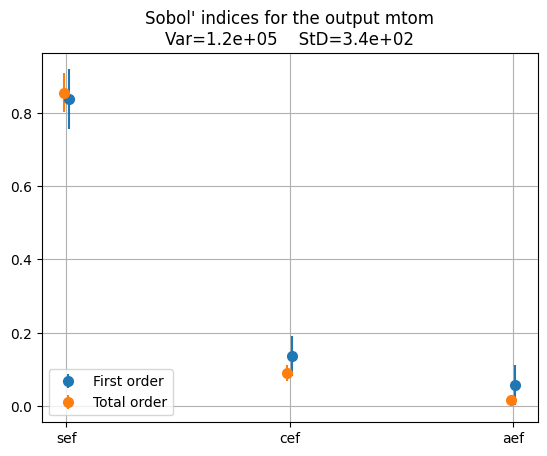

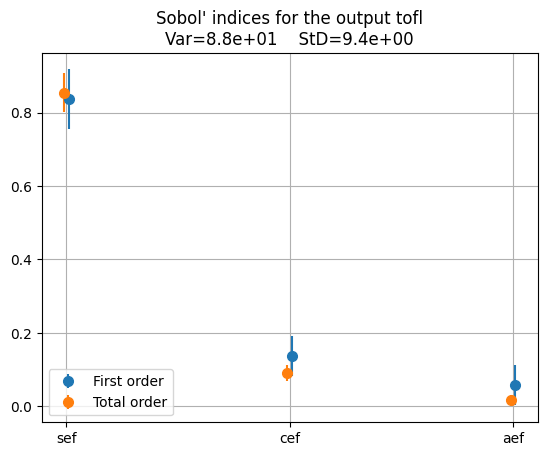

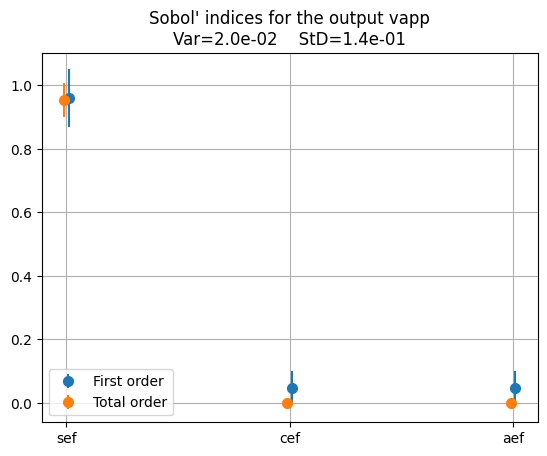

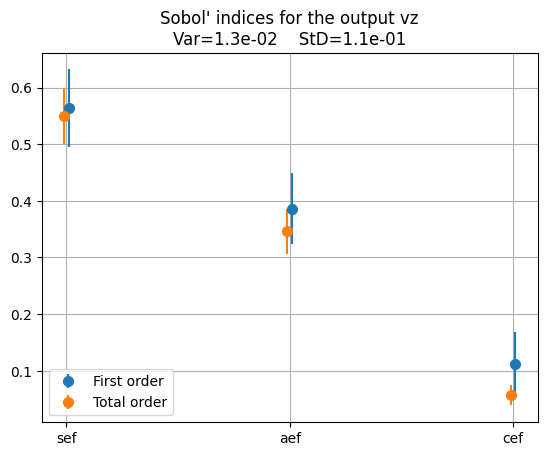

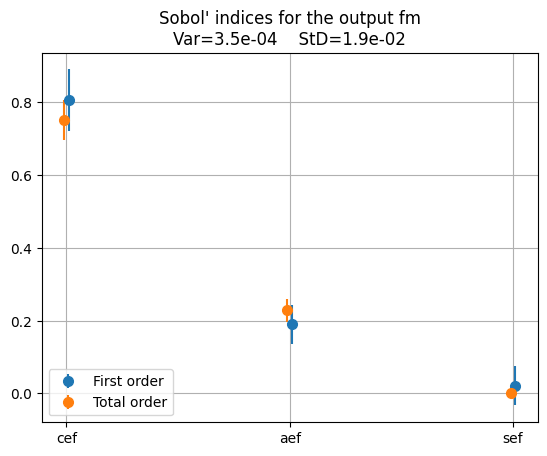

In [22]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))



